# Feature extraction and modeling
- pipeline for preprocessing and cleaning title (spacy)
- vectorization using bag of words and tfidf (sklearn)
- first modeling iteration with naive bayes and varying preprocessing

In [33]:
# imports
import time
from typing import List
from string import punctuation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# local absolute imports
from src.utils.utils import load_dataset_from_csv

In [5]:
# setup spacy model if needed
# !python -m spacy download en_core_web_sm

In [3]:
# load dataframe from csv
news = load_dataset_from_csv()

In [4]:
# load spacy models and features
nlp = spacy.load("en_core_web_sm")
stop_words = set(STOP_WORDS)
punctuation = set(punctuation)
nlp.remove_pipe("tagger")
nlp.remove_pipe("parser")
nlp.remove_pipe("ner")

# create a column for spacy processed documents
t0 = time.perf_counter()
news["spacy_title"] = news["title"].apply(lambda x : nlp(x))
t1 = time.perf_counter()
print(f"spacy tokenizing for whole dataset took {t1 - t0:0.4f} seconds")

spacy tokenizing for whole dataset took 40.2448 seconds


In [6]:
# custom spacy token post processor and filter
# tokenize, lowercase, lemmatize
# remove stopwords, punctuation, non-alphabeticals

def tokenize(doc: spacy.tokens.Doc) -> List[str]:

    # lowercase, lemmatize, strip whitespaces
    # remove non-alphabeticals, stop words, punctuation
    _tokens = (t.lemma_.lower().strip() for t in doc\
        if ((t.is_alpha) & (not t.is_stop) & (not t.is_punct)))

    return list(_tokens)


### Compare preprocessing in terms of performance and vocabulary size

In [ ]:
# split data set for first modeling iteration
train, test = train_test_split(news, test_size=0.3)

In [51]:
# custom tokenizer using spacy
bow_spacy = CountVectorizer(
    tokenizer=tokenize,
    lowercase=False
)

# default sklearn tokenizer
bow_sklearn_default = CountVectorizer(
    stop_words=None
)

# modified sklearn tokenizer with:
# stop words, alphabetical regex, max document frequency
bow_sklearn_custom = CountVectorizer(
    stop_words=STOP_WORDS,
    token_pattern=r"(?u)\b[A-Za-z]+\b",
    max_df=0.001
)

In [52]:
t0 = time.perf_counter()
x_train = bow_spacy.fit_transform(train["spacy_title"].values)
t1 = time.perf_counter()
print(f"took {t1 - t0:0.4f} seconds")
print(f"size of vocabulary using custom spacy tokenizer: {len(bow_spacy.vocabulary_)}")
print(f"final feature array shape: {x_train.shape}")

took 7.8971 seconds
size of vocabulary using custom spacy tokenizer: 41872
final feature array shape: (295693, 41872)


In [53]:
t0 = time.perf_counter()
x_train = bow_sklearn_default.fit_transform(train["title"].values)
t1 = time.perf_counter()
print(f"took {t1 - t0:0.4f} seconds")
print(f"size of vocabulary using custom spacy tokenizer: {len(bow_sklearn_default.vocabulary_)}")
print(f"final feature array shape: {x_train.shape}")

took 3.0203 seconds
size of vocabulary using custom spacy tokenizer: 47870
final feature array shape: (295693, 47870)


In [54]:
t0 = time.perf_counter()
x_train = bow_sklearn_custom.fit_transform(train["title"].values)
t1 = time.perf_counter()
print(f"took {t1 - t0:0.4f} seconds")
print(f"size of vocabulary using custom spacy tokenizer: {len(bow_sklearn_custom.vocabulary_)}")
print(f"final feature array shape: {x_train.shape}")

took 3.0012 seconds
size of vocabulary using custom spacy tokenizer: 42110
final feature array shape: (295693, 42110)


### Compare preprocessing in terms of classifier accuracy

In [57]:
# create, train and score pipeline per vectorizer

pipelines = []

for i, vectorizer in enumerate([
    ("spacy custom tokenizer", bow_spacy),
    ("sklearn default tokenizer", bow_sklearn_default),
    ("sklearn custom tokenizer", bow_sklearn_custom)
]):

    pipe = Pipeline([
        ("vectorizer", vectorizer[1]),
        ("classifier", MultinomialNB())
    ])

    # note that spacy preprocessing requires
    # the spacy.tokens.Doc type
    if vectorizer[0] == "spacy custom tokenizer":
        test_features = test["spacy_title"].values
    else:
        test_features = test["title"].values

    # fit and score pipeline for comparison
    pipe.fit(test_features, test["category"].values)
    score = pipe.score(test_features, test["category"].values)
    print(f"accuracy with {vectorizer[0]}: {score}")

    # add fitted pipeline
    pipelines.append(pipe)


accuracy with spacy custom tokenizer: 0.9336521313700424
accuracy with sklearn default tokenizer: 0.9353565961207645
accuracy with sklearn custom tokenizer: 0.8259867746161009


Text(0.5, 1.0, 'sklearn defaults')

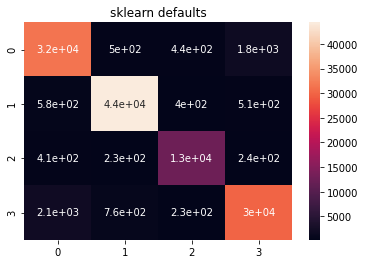

In [58]:
# visualize results for default pipeline
pipe = pipelines[1]
conf_mat = confusion_matrix(pipe.predict(test["title"].values), test["category"].values)
heat = sns.heatmap(conf_mat, annot=True)
heat.set_title("sklearn defaults")

Observations
- the additional preprocessing does not have a direct impact on accuracy
- overhead of using spacy might not be justified without further fine-tuning
- out of the box tokenizer and classifiers achieve decent results

In [59]:
demo_df = pd.DataFrame(test.iloc[1:10])
demo_df["predictions"] = pipe.predict(test.iloc[1:10]["title"])
demo_df[["title", "category", "predictions"]]

,title,category,predictions
id,,,
386197,Casey Kasem's body still unburied,e,e
188344,"Finally, Alibaba has filed for its US IPO",b,b
422729,Embryonic stem cell research: Setting the reco...,m,m
178036,Police warn of extra patrols on Cinco de Mayo,e,e
280252,'Game of Thrones' Star Kit Harington on Jon Sn...,e,e
168042,Posted by Shoaib-ur-Rehman Siddiqui,t,b
135236,Lindsay Lohan confirms she wrote leaked list i...,e,e
220293,NASA's Kepler Observatory Given New Mission,t,t
85936,Home WhatsOn ArtsEntertainment Legendary Holly...,e,e
